In [1]:
# Enabling the `widget` backend.print(totalFinalStates[1][zero_amplitude])
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib inline

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from itertools import product, combinations
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
from qiskit.providers.aer import noise, QasmSimulator
from qiskit.quantum_info import Operator, average_gate_fidelity, state_fidelity

from numpy import pi
from math import e
from matplotlib import colors, cm
from matplotlib.ticker import PercentFormatter
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal, CompleteMeasFitter, TensoredMeasFitter)

import matplotlib.pyplot as plt
import numpy as np
import math
from src.quantum_channel_discrimination import plot_probabilities2, run_base_circuit, plot_surface_probabilities, plot_wireframe_blochs, plot_surface_blochs, plot_fidelity, prepare_and_plot_probabilities
from qiskit.test.mock import FakeAthens, FakeVigo
# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [10]:
points_theta = 20  # Points of Theta angle (pi) in Bloch sphere - min 2
points_phase = 10  # Points of Phase angle (2*pi) in Bloch sphere - min 2
# angles shift from first parameter, to the second one, with jumps using the third parameter
angles_eta = [0, pi/4, pi/2, 3*pi/4, pi]
# angles_eta = np.arange(0, np.pi, 2*np.pi/(points_theta*points_phase))
out_rz_angle=0
out_ry_angle=0



noisy_backend = FakeAthens()
device_backend = FakeVigo()
vigo_simulator = QasmSimulator.from_backend(device_backend)
# backend_sim=Aer.get_backend('qasm_simulator')
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx", "cry"])
noisy_simulator = QasmSimulator(noise_model=noise_bit_flip)

# QuantumError objects
error_reset_phase = pauli_error([('Z', p_reset), ('I', 1 - p_reset)])
error_meas_phase = pauli_error([('Z',p_meas), ('I', 1 - p_meas)])
error_gate1_phase = pauli_error([('Z',p_gate1), ('I', 1 - p_gate1)])
error_gate2_phase = error_gate1_phase.tensor(error_gate1_phase)

# Add errors to noise model
noise_sign_flip = NoiseModel()
noise_sign_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_sign_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_sign_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_sign_flip.add_all_qubit_quantum_error(error_gate2, ["cx", "cry"])
noisy_sign_simulator = QasmSimulator(noise_model=noise_sign_flip)


In [11]:
initialStates, totalResults, totalCounts, totalCircuits, totalFinalStates, anglesPhase, Z_Output0, Z_Output1, X_Input0, X_Input1, Y_Eta, initialStatesReshaped, allChannelsFinalStatesReshaped, eta_degrees = run_base_circuit(angles_eta=angles_eta, points_theta=points_theta, points_phase=points_phase, iterations=2000, out_rz_angle=out_rz_angle, out_ry_angle=out_ry_angle, backend=noisy_sign_simulator)

Simulating channel with η = 0°


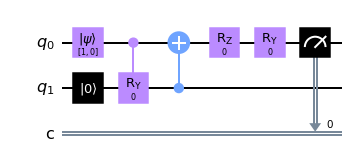

In [4]:
totalCircuits[0][0].draw('mpl')

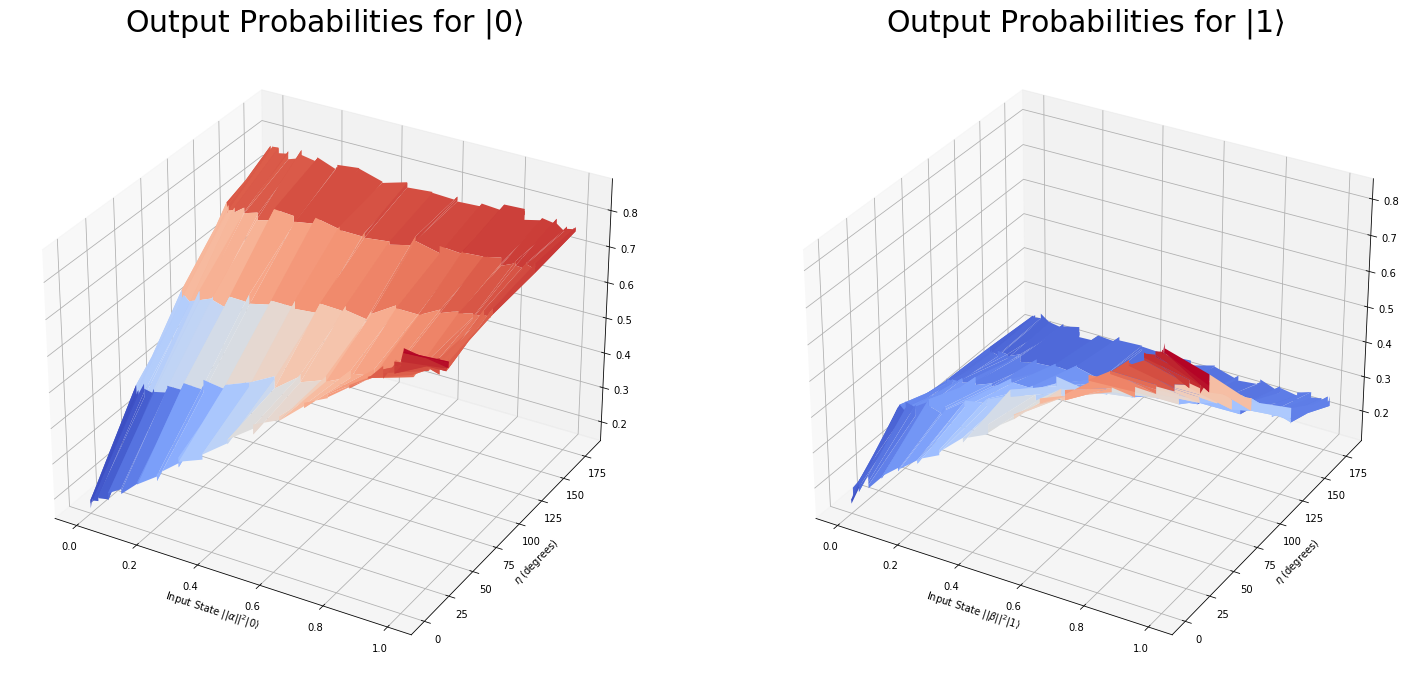

In [12]:
plot_surface_probabilities(X_Input0, X_Input1, Z_Output0, Z_Output1, eta_degrees)

In [6]:
def draw_cube(axes):
    """ Draw a cube passing axes as a parameter """
    r = [-1, 1]
    for s, l in combinations(np.array(list(product(r, r, r))), 2):
        if np.sum(np.abs(s - l)) == r[1] - r[0]:
            axes.plot3D(*zip(s, l), color="w")

In [7]:
def plot_wireframe_blochs_in(initialStatesReshaped, allChannelsFinalStatesReshaped, anglesEta, rows=3, cols=3):
    fig = plt.figure(figsize=(20, 25))
    # ===============
    #  First subplot
    # ===============
    # set up the axes for the first plot
    ax = fig.add_subplot(rows, cols, 1, projection='3d')
    draw_cube(ax)

    # draw initial states
    ax.plot_wireframe(initialStatesReshaped['reshapedCoordsX'],
                      initialStatesReshaped['reshapedCoordsY'],
                      initialStatesReshaped['reshapedCoordsZ'], color="c")
    ax.set_title("Input States")
    # draw center
    ax.scatter([0], [0], [0], color="g", s=50)

    # ===============
    # Next subplots
    # ===============

    indexFinalStateReshaped = 0
    modulus_number = np.round(len(allChannelsFinalStatesReshaped) / (rows * cols - 1))
    index_to_print = 0
    for finalStatesReshaped in allChannelsFinalStatesReshaped:
        if ((index_to_print == 0 or len(allChannelsFinalStatesReshaped) < modulus_number) or
                (index_to_print != 0 and indexFinalStateReshaped % modulus_number == 0 and
                 index_to_print < (rows * cols - 1))):
            # set up the axes for the second plot
            ax = fig.add_subplot(rows, cols, 2 + index_to_print, projection='3d')
            draw_cube(ax)
            # draw final states
            ax.plot_wireframe(finalStatesReshaped['reshapedCoordsX'],
                              finalStatesReshaped['reshapedCoordsY'],
                              finalStatesReshaped['reshapedCoordsZ'], color="r")
            title = "Output States\n Channel " + "$\eta=" + \
                str(int(math.degrees(anglesEta[indexFinalStateReshaped]))) + "\degree$"
            ax.set_title(title)
            # draw center
            ax.scatter([0], [0], finalStatesReshaped["center"], color="g", s=50)
            index_to_print += 1
        indexFinalStateReshaped += 1

    plt.show()

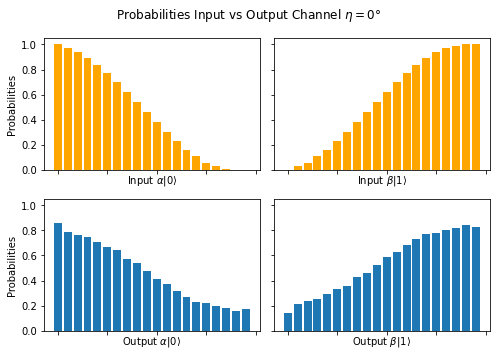

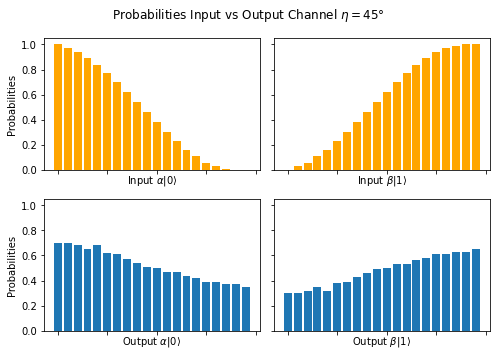

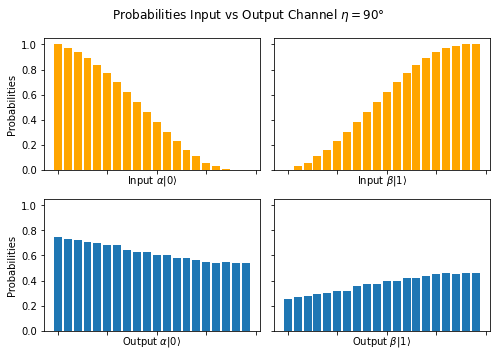

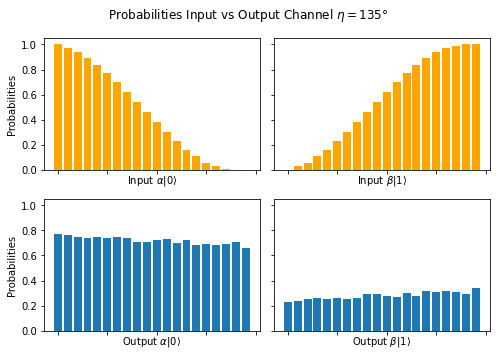

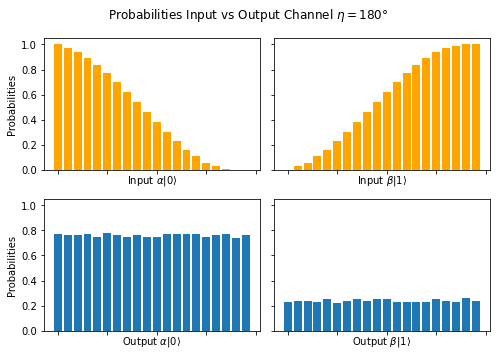

In [13]:
prepare_and_plot_probabilities(angles_eta, initialStates, totalFinalStates)

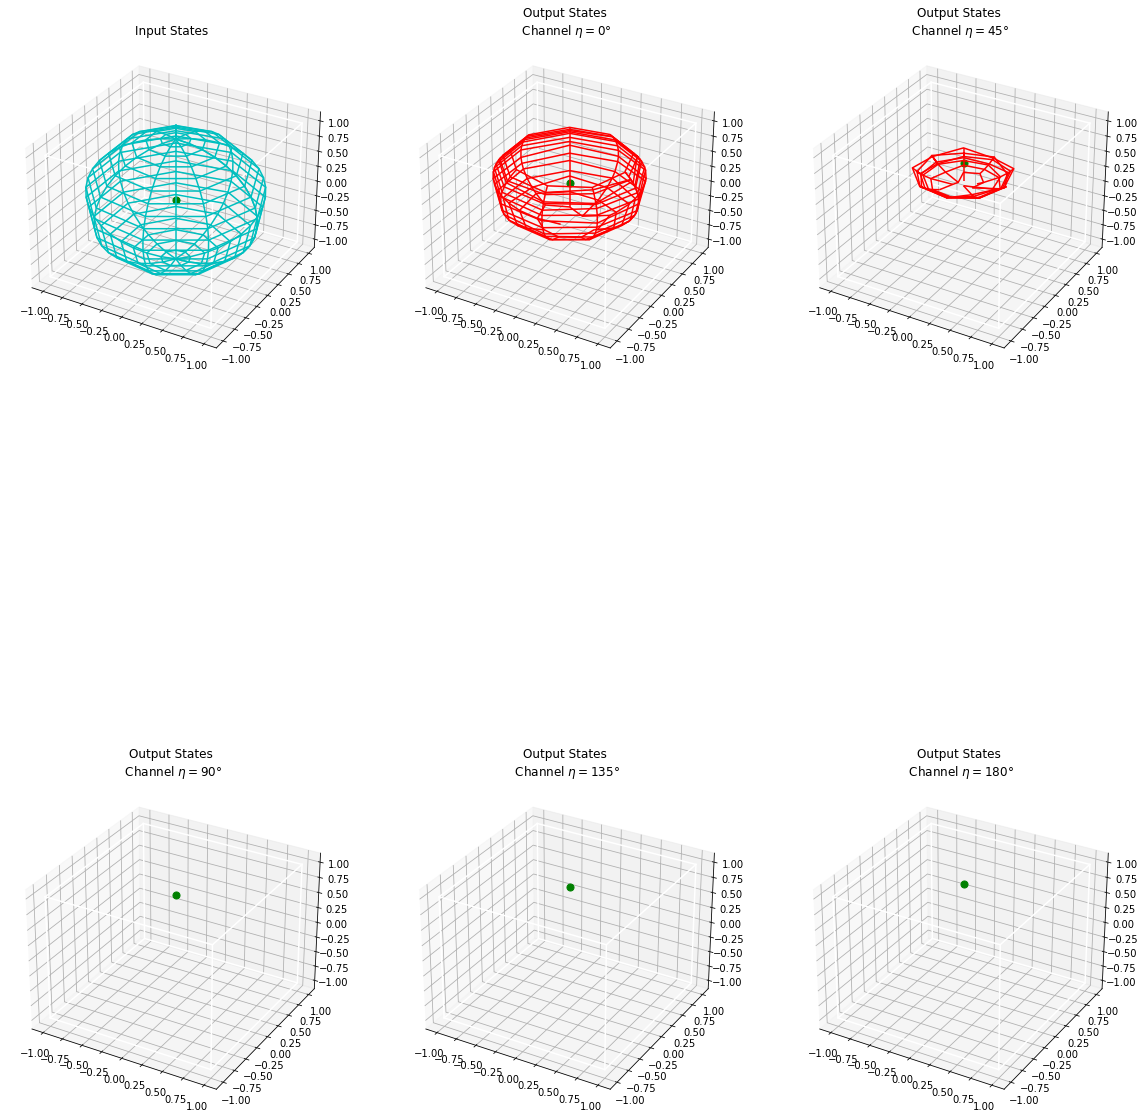

In [14]:
plot_wireframe_blochs_in(initialStatesReshaped, allChannelsFinalStatesReshaped, angles_eta, 2, 3)

In [6]:
angles_eta

[0, 2.0943951023931953]

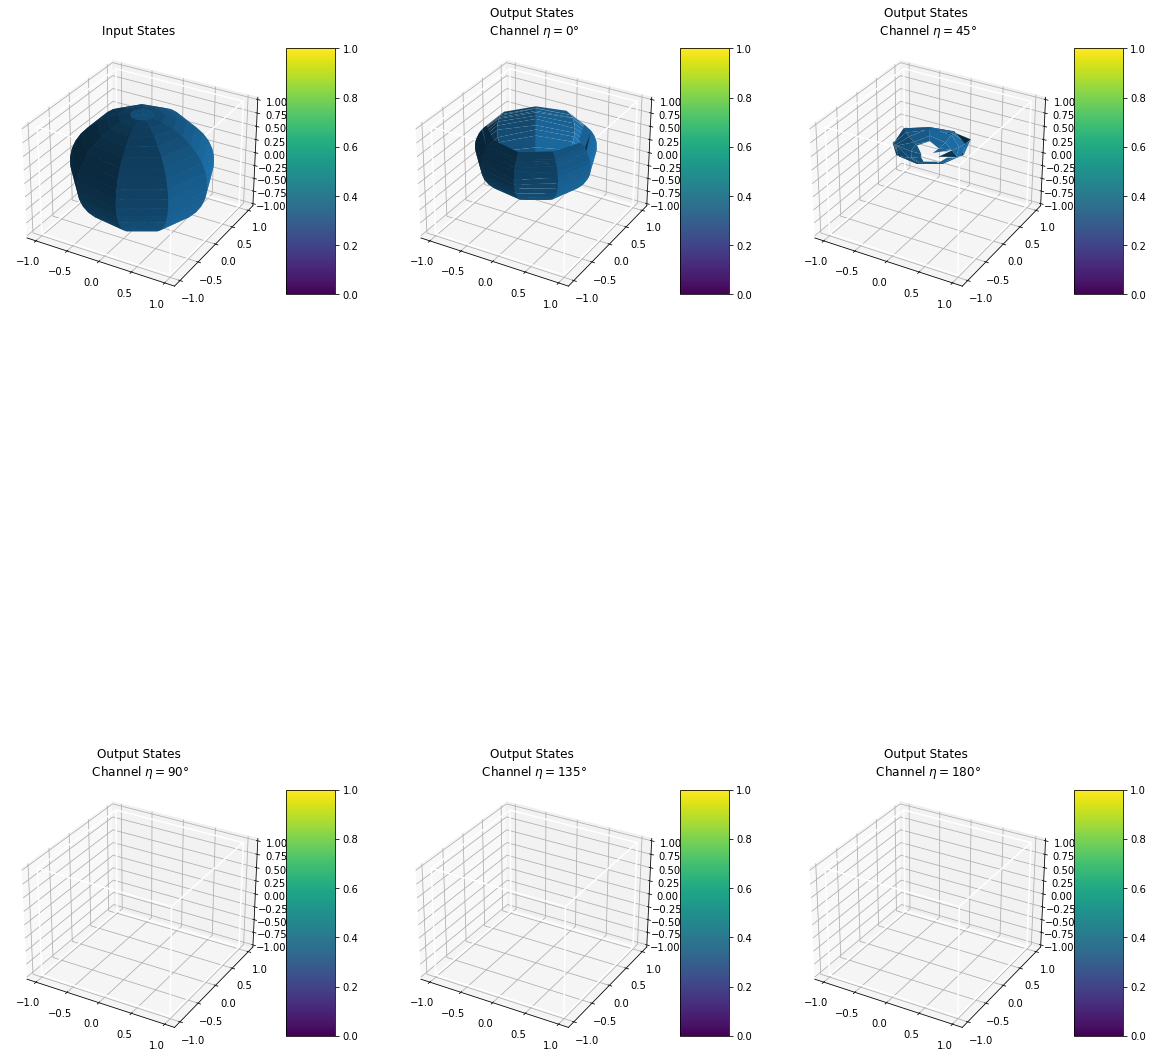

In [9]:
plot_surface_blochs(initialStatesReshaped, allChannelsFinalStatesReshaped, angles_eta, rows=2, cols=3)

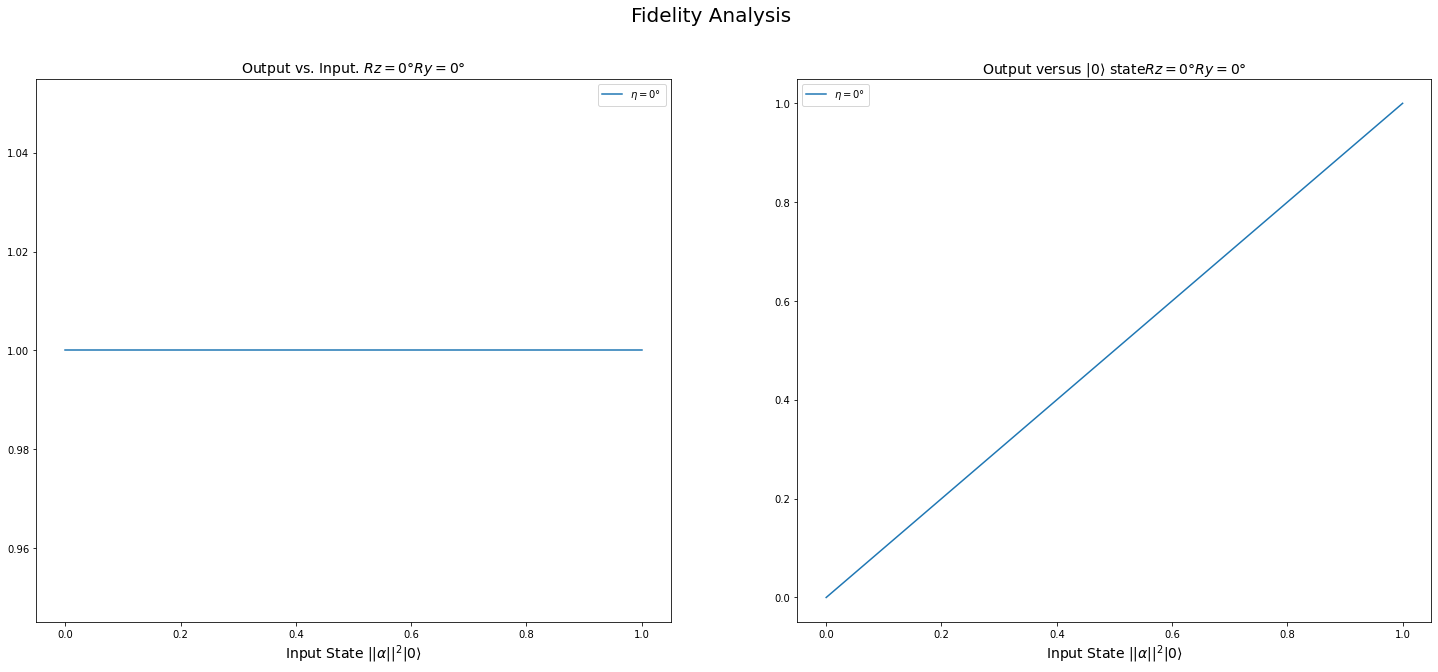

In [27]:
plot_fidelity(angles_eta, pointsTheta=points_theta)